# Setup
Importing files and importing libraries

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

In [2]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

## Notes to self:
1. Images are in folder 'patch_images'

2. Dataset has the following columns: InstanceID, patientID, ImageName, cellTypeName, cellType, isCancerous
- data_labels_mainData.csv - has all the columns stated above
- data_labels_extraData.csv - does not have cellTypeName & cellType

Not sure how to deal with the extra dataset so I'll just use the main one first

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


# EDA
Definitely need to add more EDA

In [8]:
train_data.head(20)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
9533,22266,58,22266.png,fibroblast,0,0
310,18717,4,18717.png,others,3,0
9480,21202,57,21202.png,inflammatory,1,0
7073,18114,44,18114.png,fibroblast,0,0
8977,14070,54,14070.png,epithelial,2,1
2436,3153,14,3153.png,epithelial,2,1
5074,16923,29,16923.png,inflammatory,1,0
2866,8791,17,8791.png,epithelial,2,1
7092,18134,44,18134.png,inflammatory,1,0
1211,4952,8,4952.png,epithelial,2,1


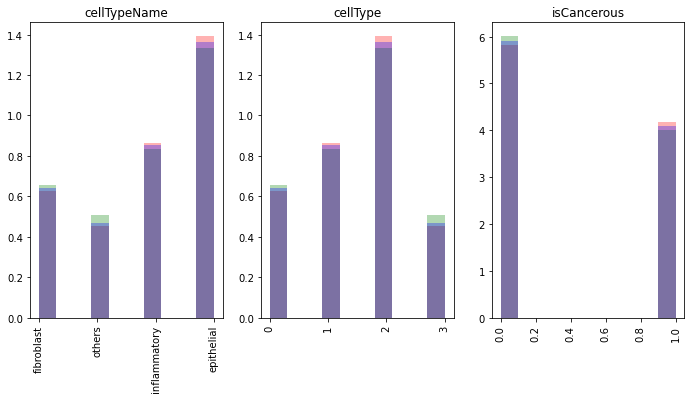

In [9]:
# plt.figure(figsize=(20,20))
# for i, col in enumerate(train_data.columns):
#     plt.subplot(4,5,i+1)
#     _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
#     _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
#     plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
#     plt.title(col)
#     plt.xticks(rotation='vertical')

plt.figure(figsize=(20,25))
for i, col in enumerate(['cellTypeName','cellType', 'isCancerous']):
    plt.subplot(4,5,i+1)
    _, bins, _ = plt.hist(train_data[col], alpha=0.3, color='r', density=True)
    _, bins2, _ = plt.hist(test_data[col], bins=bins, alpha=0.3, color='g', density=True)
    plt.hist(val_data[col], bins=bins2, alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')

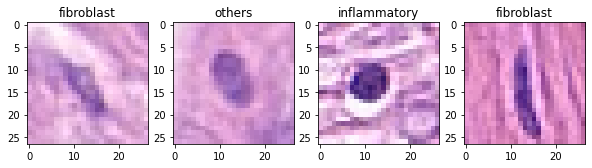

In [14]:
from PIL import Image

label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['cellType']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [15]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


# Model Development
Our assignment has 2 parts:
- Classify images according to whether given cell image represents a cancerous cellsor not (isCancerous).
- Classify images according to cell-type, such as: fibroblast,inflammatory,epithelial or others.

I'll start with the 2nd point first - Classify images according to cell-type

### Initializing the model

In [16]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

## Mock Base Model
Just playing around

In [17]:
INPUT_DIM = (32,32,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 10

In [18]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
_________________________________________________________________


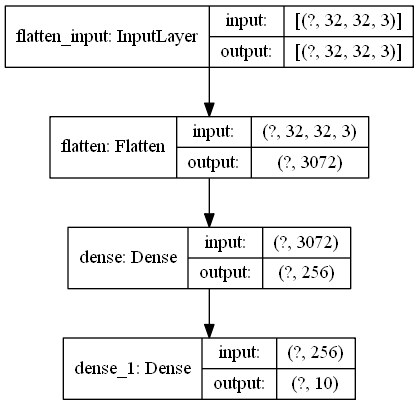

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

### Training the Model

In [22]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [29]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

InvalidArgumentError:  Input to reshape is a tensor with 69984 values, but the requested shape requires a multiple of 3072
	 [[node sequential/flatten/Reshape (defined at <ipython-input-24-243f5d5117d3>:1) ]] [Op:__inference_train_function_476]

Function call stack:
train_function
